In [1]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel
from torch.amp import autocast
import torchvision.transforms as T
import warnings 
warnings.filterwarnings('ignore')

class MLPFusion(nn.Module):
    def __init__(self, num_classes, device='cuda', seed=0):
        super().__init__()
        self.device = device
        
        # Set seeds for reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        # Initialize models and processors
        self.models = {
            'dino': AutoModel.from_pretrained('facebook/dinov2-small'),
            'convnext': AutoModel.from_pretrained('facebook/convnext-large-224'),
            'vit': AutoModel.from_pretrained('google/vit-base-patch16-224-in21k')
        }
        
        self.processors = {
            'dino': AutoImageProcessor.from_pretrained('facebook/dinov2-small',do_rescale=False),
            'convnext': AutoImageProcessor.from_pretrained('facebook/convnext-large-224',do_rescale=False),
            'vit': AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k',do_rescale=False, use_fast=True)
        }
        
        # Move models to device and enable fine-tuning
        for model in self.models.values():
            model.to(device)
            for param in model.parameters():
                param.requires_grad = False
        
        # Feature dimensions
        feature_dims = {
            'dino': 384,
            'convnext': 1536,
            'vit': 768
        }
        
        # Projection layers for each model
        proj_dim = 256  # Common projection dimension
        self.projections = nn.ModuleDict({
            'dino': nn.Sequential(
                nn.Linear(feature_dims['dino'], proj_dim),
                nn.LayerNorm(proj_dim),
                nn.GELU(),
                nn.Dropout(0.1)
            ),
            'convnext': nn.Sequential(
                nn.Linear(feature_dims['convnext'], proj_dim),
                nn.LayerNorm(proj_dim),
                nn.GELU(),
                nn.Dropout(0.1)
            ),
            'vit': nn.Sequential(
                nn.Linear(feature_dims['vit'], proj_dim),
                nn.LayerNorm(proj_dim),
                nn.GELU(),
                nn.Dropout(0.1)
            )
        }).to(device)
        
        # Feature weighting (learnable)
        self.feature_weights = nn.Parameter(torch.ones(3, proj_dim) / 3).to(device)
        
        # Enhanced MLP fusion head with residual connections
        self.fusion_mlp = nn.Sequential(
            nn.Linear(proj_dim * 3, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.2),
            ResidualBlock(512, 256),
            ResidualBlock(256, 128),
            nn.Linear(128, num_classes)
        ).to(device)
        
        # Batch norm for final feature normalization
        self.feature_norm = nn.BatchNorm1d(proj_dim * 3).to(device)

    def extract_features(self, image):
        all_features = []
        
        # Process image for each model
        for name, model in self.models.items():
            processor = self.processors[name]
            inputs = processor(images=image, return_tensors="pt").to(self.device)
            
            with autocast(self.device):
                output = model(**inputs)
                # Get CLS token or global pooled features
                if name == 'dino' or name == 'vit':
                    features = output.last_hidden_state[:, 0]
                else:
                    features = output.pooler_output
                
                # Project features
                features = self.projections[name](features)
                all_features.append(features)
        
        return all_features

    def forward(self, x):
        # Extract features
        features = self.extract_features(x)
        
        # Apply learned weights to each model's features
        weighted_features = [feat * weight for feat, weight in zip(features, self.feature_weights)]
        
        # Concatenate features
        combined_features = torch.cat(weighted_features, dim=1)
        
        # Normalize concatenated features
        combined_features = self.feature_norm(combined_features)
        
        # Pass through MLP
        output = self.fusion_mlp(combined_features)
        return output

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.linear2 = nn.Linear(out_features, out_features)
        self.norm1 = nn.LayerNorm(out_features)
        self.norm2 = nn.LayerNorm(out_features)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        
        # Projection shortcut if dimensions don't match
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.linear1(x)
        out = self.norm1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.linear2(out)
        out = self.norm2(out)
        
        out += identity
        out = self.activation(out)
        
        return out

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gc
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class WeatherDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Collect all images and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image =  Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

def get_dataloaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    classes = [i for i in os.listdir(data_dir)]
    dataset = WeatherDataset(data_dir, classes, transform=transform)
    
    # Split indices: 70% train, 15% val, 15% test
    train_size = 0.7
    val_size = 0.15
    test_size = 0.15
    
    # First split into train and temp
    train_idx, temp_idx = train_test_split(
        range(len(dataset)),
        test_size=(val_size + test_size),
        stratify=dataset.labels,
        random_state=42
    )
    
    # Split temp into val and test
    rel_val_size = val_size / (val_size + test_size)
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,  # 50% of temp goes to test
        stratify=[dataset.labels[i] for i in temp_idx],
        random_state=42
    )
    
    # Create samplers
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    # Create loaders
    train_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=val_sampler,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=test_sampler,
        num_workers=4,
        pin_memory=True
    )
    return train_loader, val_loader, test_loader, len(classes)

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, train_loader, val_loader, num_epochs=100, patience=5,checkpoint_path = 'best_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        torch.cuda.empty_cache()
        gc.collect()
        for images, labels in tqdm(train_loader):
            #torch.cuda.empty_cache()
            #gc.collect()
            images, labels = images.to(model.device), labels.to(model.device)
            optimizer.zero_grad()

            with autocast(model.device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        torch.cuda.empty_cache()
        gc.collect()        
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch}, Average Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                #torch.cuda.empty_cache()
                #gc.collect()
                images = images.to(model.device)
                labels = labels.to(model.device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        print(f'Epoch: {epoch}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

        # Step the scheduler
        scheduler.step(avg_val_loss)

        # Early Stopping
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    
    # Lists to store predictions and ground truth
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, 
                                                             all_predictions, 
                                                             average='weighted')
    
    # Calculate per-class metrics
    class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(all_labels, 
                                                                               all_predictions, 
                                                                               average=None)
    
    # Get class names from test_loader
    class_names = test_loader.dataset.classes
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Print overall metrics
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print per-class metrics
    print("\nPer-class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"Precision: {class_precision[i]:.4f}")
        print(f"Recall: {class_recall[i]:.4f}")
        print(f"F1 Score: {class_f1[i]:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_precision': class_precision,
        'class_recall': class_recall,
        'class_f1': class_f1,
        'confusion_matrix': cm
    }

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/791M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

100%|██████████| 146/146 [31:38<00:00, 13.00s/it]


Epoch 0, Average Training Loss: 0.9285


100%|██████████| 32/32 [06:52<00:00, 12.88s/it]


Epoch: 0, Validation Loss: 0.6807, Validation Accuracy: 76.88%
Validation loss improved (inf --> 0.680694).  Saving model ...


100%|██████████| 146/146 [31:22<00:00, 12.89s/it]


Epoch 1, Average Training Loss: 0.6481


100%|██████████| 32/32 [06:48<00:00, 12.76s/it]


Epoch: 1, Validation Loss: 0.6377, Validation Accuracy: 78.14%
Validation loss improved (0.680694 --> 0.637737).  Saving model ...


100%|██████████| 146/146 [31:36<00:00, 12.99s/it]


Epoch 2, Average Training Loss: 0.5841


100%|██████████| 32/32 [06:54<00:00, 12.96s/it]


Epoch: 2, Validation Loss: 0.6309, Validation Accuracy: 78.37%
Validation loss improved (0.637737 --> 0.630859).  Saving model ...


100%|██████████| 146/146 [31:38<00:00, 13.00s/it]


Epoch 3, Average Training Loss: 0.5403


100%|██████████| 32/32 [06:51<00:00, 12.85s/it]


Epoch: 3, Validation Loss: 0.6217, Validation Accuracy: 79.11%
Validation loss improved (0.630859 --> 0.621687).  Saving model ...


100%|██████████| 146/146 [31:20<00:00, 12.88s/it]


Epoch 4, Average Training Loss: 0.5045


100%|██████████| 32/32 [06:47<00:00, 12.75s/it]


Epoch: 4, Validation Loss: 0.6356, Validation Accuracy: 78.88%
EarlyStopping counter: 1 out of 5


100%|██████████| 146/146 [31:19<00:00, 12.87s/it]


Epoch 5, Average Training Loss: 0.4713


100%|██████████| 32/32 [06:48<00:00, 12.77s/it]


Epoch: 5, Validation Loss: 0.6463, Validation Accuracy: 78.95%
EarlyStopping counter: 2 out of 5


100%|██████████| 146/146 [31:27<00:00, 12.93s/it]


Epoch 6, Average Training Loss: 0.4370


100%|██████████| 32/32 [06:49<00:00, 12.80s/it]


Epoch: 6, Validation Loss: 0.6623, Validation Accuracy: 78.83%
EarlyStopping counter: 3 out of 5


100%|██████████| 146/146 [31:26<00:00, 12.92s/it]


Epoch 7, Average Training Loss: 0.4068


100%|██████████| 32/32 [06:50<00:00, 12.82s/it]


Epoch: 7, Validation Loss: 0.6811, Validation Accuracy: 78.66%
EarlyStopping counter: 4 out of 5


100%|██████████| 146/146 [31:21<00:00, 12.89s/it]


Epoch 8, Average Training Loss: 0.3491


100%|██████████| 32/32 [06:51<00:00, 12.85s/it]


Epoch: 8, Validation Loss: 0.6865, Validation Accuracy: 78.60%
EarlyStopping counter: 5 out of 5
Early stopping


Evaluating: 100%|██████████| 32/32 [06:53<00:00, 12.94s/it]



Overall Metrics:
Accuracy: 0.7820
Precision: 0.7815
Recall: 0.7820
F1 Score: 0.7801

Per-class Metrics:

unknown:
Precision: 0.6385
Recall: 0.7665
F1 Score: 0.6967

partly cloudy:
Precision: 0.5345
Recall: 0.4591
F1 Score: 0.4939

clear:
Precision: 0.8853
Recall: 0.8929
F1 Score: 0.8891

overcast:
Precision: 0.6180
Recall: 0.6278
F1 Score: 0.6229

snowy:
Precision: 0.7757
Recall: 0.7413
F1 Score: 0.7581

foggy:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

rainy:
Precision: 0.7928
Recall: 0.6326
F1 Score: 0.7037


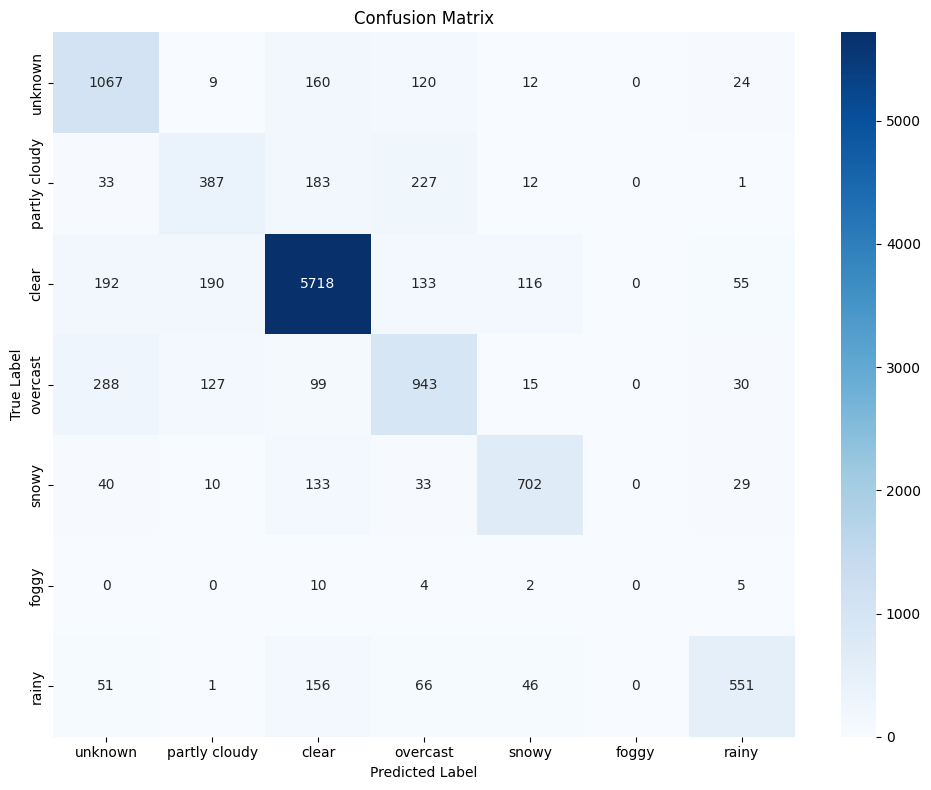

In [4]:
train_loader, val_loader, test_loader,n_classes = get_dataloaders('/kaggle/input/bdd100k/data', 384)

model = MLPFusion(num_classes=n_classes)
train_model(model, train_loader, val_loader)
metrics = evaluate_model(model, test_loader)